In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import logging
import pypsa
import os.path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from plot_summary import rename_techs
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from plot_network import plot_capex_map, plot_map, plot_energy_map
from _plot_utilities import fix_network_names_colors

logger = logging.getLogger(__name__)


In [157]:

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    opts="ll",
    topology="current+Neighbor",
    pathway="exponential175",
    planning_horizons="2060",
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network

# ntw_path = "/home/ivanra/documents/PyPSA-China-PIK/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
# ntw_path = "/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
n = pypsa.Network(ntw_path)

2024-12-16 18:35:41,905 - _helpers.py - INFO - =========== NEW RUN ===========
2024-12-16 18:35:41,905 - _helpers.py - INFO - =========== NEW RUN ===========
INFO:__main__:=========== NEW RUN ===========
INFO:pypsa.io:Imported network postnetwork-ll-current+Neighbor-exponential175-2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [112]:
fix_network_names_colors(n, config)

/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.carriers.color.fillna(NAN_COLOR, inplace=True)


In [113]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-131.310932


# plot map

In [114]:
from plot_network import plot_capex_map, plot_map

## plot capex

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


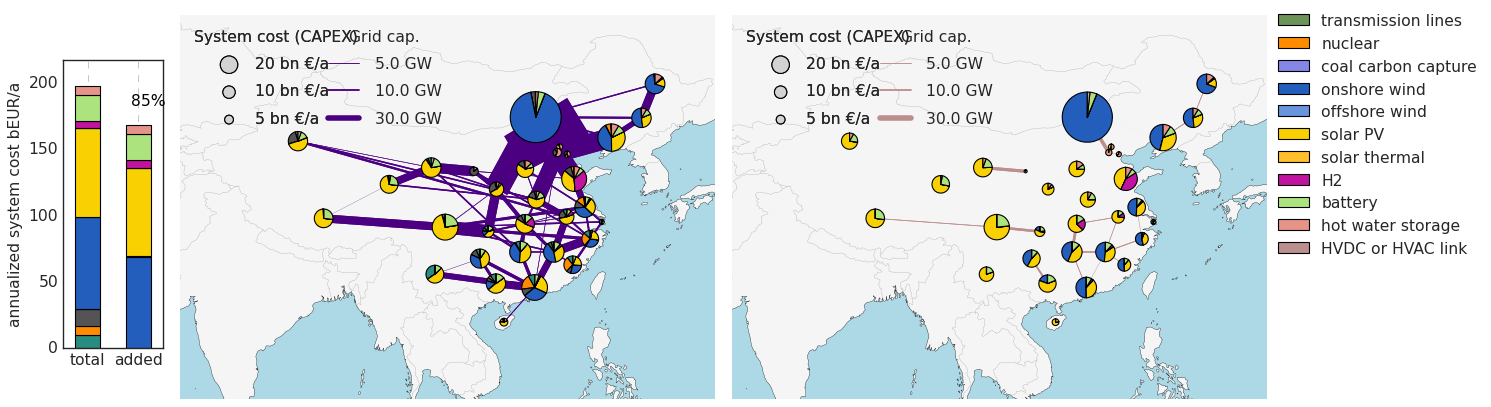

In [115]:
ax = plot_capex_map(n, 2060, snakemake.config["costs"]["discountrate"], config["plotting"])

# TODO: check costs map with stats

In [116]:
from _plot_utilities import assign_location
from plot_network import plot_map
opts = config["plotting"]
plot_ntwk = n.copy()
assign_location(plot_ntwk)
cpx = plot_ntwk.statistics.capex(groupby=pypsa.statistics.get_bus_and_carrier)
cpx2 = cpx.droplevel(0)

In [117]:
anhui_stats = cpx.unstack().groupby(level=1).sum().loc["Anhui"]
anhui_stats.index = anhui_stats.index.map(rename_techs)
anhui_stats.where(anhui_stats > 0).dropna().sort_index()

carrier
Battery Storage         2.630043e+08
Heat Pump               4.559860e+08
Hydrogen Storage        3.205197e+05
Onshore Wind            7.136655e+05
Pumped Hydro Storage    2.701888e+08
Solar                   4.064781e+09
coal                    5.601667e+04
coal                    1.616829e+09
hydroelectricity        3.680158e+08
resistive heater        6.128118e+07
transmission lines      4.213870e+09
Name: Anhui, dtype: float64

In [118]:
from _helpers import calc_component_capex
from _plot_utilities import assign_location
from plot_network import make_cost_pies
costs_add = pd.DataFrame(index=n.buses.index)
costs_nom = pd.DataFrame(index=n.buses.index)
plot_ntwk = n.copy()
# Drop non-electric buses so they don't clutter the plot
plot_ntwk.buses.drop(plot_ntwk.buses.index[plot_ntwk.buses.carrier != "AC"], inplace=True)

assign_location(plot_ntwk)
for comp in plot_ntwk.iterate_components():
    # df_c = getattr(ntwk, comp)
    print(comp.name, comp.list_name)
    df_c = comp.df

    if df_c.empty:
        continue
    if not "capital_cost" in df_c.columns:
        continue

    df_c["nice_group"] = comp.name + "_" + df_c.carrier #.map(rename_techs)

    cap_name = "e_nom_opt" if comp.list_name == "stores" else "p_nom_opt"
    cap_before_ext = "e_nom" if comp.list_name == "stores" else "p_nom"

    costs_total = calc_component_capex(df_c, cap_name)
    costs_before_ext = calc_component_capex(df_c, cap_before_ext)
    costs_diff = costs_total - costs_before_ext

    costs_add = pd.concat([costs_add, costs_diff], axis=1)
    costs_nom = pd.concat([costs_nom, costs_total], axis=1)

costs_pathway = costs_add
cost_pie = make_cost_pies(plot_ntwk, costs_pathway, tech_colors)
cost_pie_nom = make_cost_pies(plot_ntwk, costs_nom, tech_colors)

       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_resistive heater', 'Store_H2', 'Store_battery',
       'Store_water tanks'],
      dtype='object')
       'Generator_hydroelectricity', 'Generator_nuclear', 'Generator_offwind',
       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_hydroelectricity', 'Link_resistive heater',
       'StorageUnit_PHS', 'Store_H2', 'Store_battery', 'Store_water tanks'],
      dtype='object')


GlobalConstraint global_constraints
StorageUnit storage_units
TransformerType transformer_types
Generator generators
Load loads
Carrier carriers
Bus buses
LineType line_types
Link links
Store stores


## plot electricy generation map

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:467: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:428: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


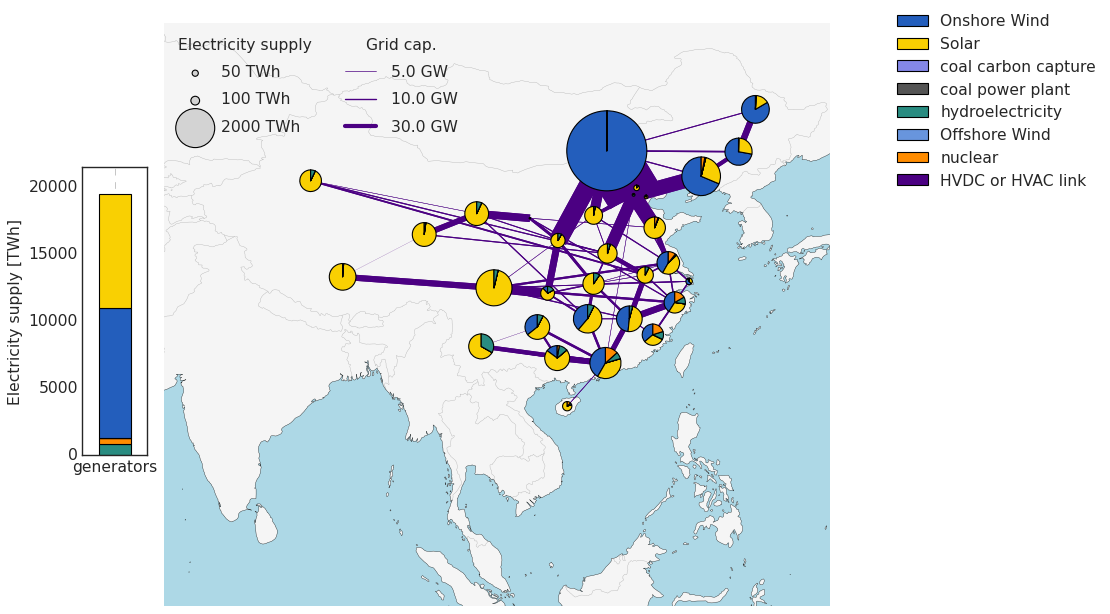

In [119]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="AC")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: >

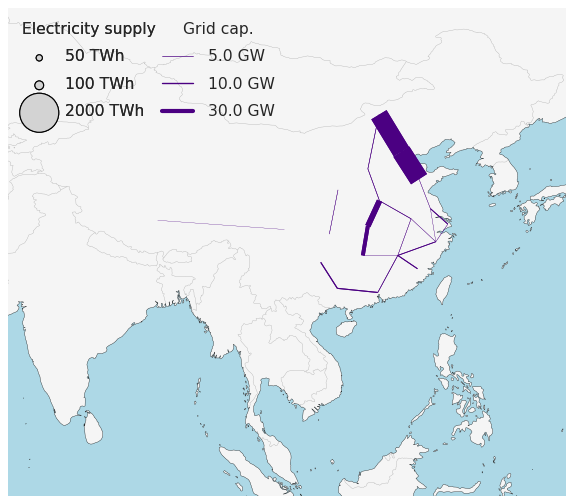

In [120]:
plot_h2_ntwk = n.copy()
carrier = "H2"
# avoid cluttering the plot
plot_h2_ntwk.buses.drop(plot_h2_ntwk.buses.index[plot_h2_ntwk.buses.carrier != carrier], inplace=True)
plot_h2_ntwk.links.drop(
    plot_h2_ntwk.links.index[plot_h2_ntwk.links.carrier != carrier],
    inplace=True,
)

supply_pies = plot_h2_ntwk.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=carrier, comps=["Generator"]
    ).droplevel(0)

# get all carrier types
carriers_list = supply_pies.index.get_level_values(1).unique()
carriers_list = carriers_list.tolist()

# TODO make line handling nicer
line_lower_threshold = 500.0
line_upper_threshold = 1e4
# Make figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(opts["energy_map"]["figsize"])
# get colors
bus_colors = plot_h2_ntwk.carriers.loc[plot_h2_ntwk.carriers.nice_name.isin(carriers_list), "color"]
bus_colors.rename(opts["nice_names"], inplace=True)
# Add the total costs
bus_size_factor = opts["energy_map"]["bus_size_factor"]/1e2
linewidth_factor = opts["energy_map"]["linewidth_factor"]*1
edges = pd.concat([plot_h2_ntwk.lines.s_nom_opt, plot_h2_ntwk.links.p_nom_opt])
edge_widths = (
    edges
    .clip(line_lower_threshold, edges.max())
    .replace(line_lower_threshold, 0)
)
preferred_order = pd.Index(opts["preferred_order"])
reordered = preferred_order.intersection(bus_colors.index).append(
    bus_colors.index.difference(preferred_order)
)

plot_map(
    plot_h2_ntwk,
    tech_colors=plot_h2_ntwk.carriers.color,
    edge_widths=edge_widths / linewidth_factor,
    bus_colors=bus_colors.loc[reordered],
    bus_sizes=supply_pies / 1,
    edge_colors="indigo",
    ax=ax,
    edge_unit_conv=PLOT_CAP_UNITS,
    bus_unit_conv=PLOT_SUPPLY_UNITS,
    add_legend=False,
    **opts["energy_map"],
)

## plot capacity

## plot cost

## Interactive plot map

In [121]:

import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/p/tmp/ivanra/anaconda/ipykernel_2238981/1096144582.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""


In [122]:
n.links[(n.links.length != 0)&(n.links.index.str.find("reversed")<0)].p_nom_opt.sort_values(ascending=False).round(2).head(20)

Link
Hebei-InnerMongolia positive                397397.77
Hebei-Shandong H2 pipeline positive         136711.84
InnerMongolia-Shaanxi positive              132015.65
Hebei-InnerMongolia H2 pipeline positive    128568.46
Hebei-Shandong positive                     106453.60
Hebei-Liaoning positive                     105330.93
Hebei-Henan positive                         85544.81
InnerMongolia-Shanxi positive                70469.15
Chongqing-Sichuan positive                   69089.18
Gansu-Ningxia positive                       54356.32
Chongqing-Shaanxi positive                   49591.35
Jiangxi-Zhejiang positive                    46597.17
Heilongjiang-Jilin positive                  45223.80
Sichuan-Tibet positive                       43794.68
Guangdong-Guangxi ext positive               41690.00
Gansu-Qinghai positive                       40305.29
Henan-Hubei H2 pipeline positive             39864.73
Anhui-Jiangxi positive                       36893.38
Guangdong-Jiangxi posit

### extendable lines

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


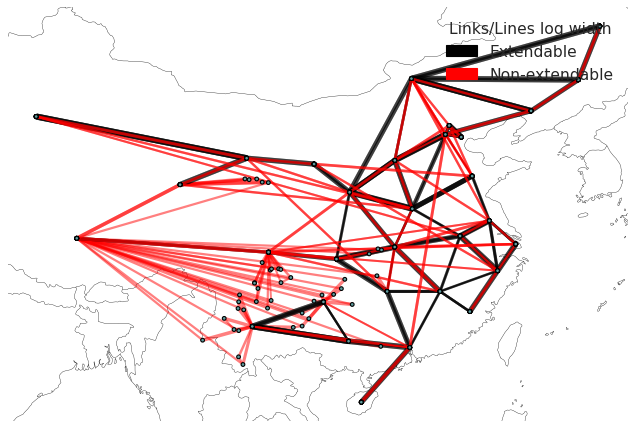

In [123]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10),subplot_kw={"projection":ccrs.PlateCarree()})
def width(x):
    return np.log10(x/1e6).where(x>1,0)
n.plot(ax = ax,link_colors=n.links.p_nom_extendable.apply(lambda x: "red" if not x else "black"),line_colors=n.lines.s_nom_extendable.apply(lambda x: "red" if not x else "black"), link_widths= width(n.links.p_nom_opt) , line_widths=width(n.lines.s_nom_opt), link_alpha=0.5)
# Create custom legend
import matplotlib.patches as mpatches
extendable_patch = mpatches.Patch(color='black', label='Extendable')
non_extendable_patch = mpatches.Patch(color='red', label='Non-extendable')
ax.legend(handles=[extendable_patch, non_extendable_patch], title = "Links/Lines log width")

# Shadow prices & prices

In [124]:
from make_summary import make_summaries
summaries = make_summaries({("exp175-paper", 2060):ntw_path})

INFO:make_summary:Make summary for scenario ('exp175-paper', 2060), using /p/tmp/ivanra/PyPSA-China-PIK/results/version-PIK-VAL1/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc


INFO:pypsa.io:Imported network postnetwork-ll-current+Neighbor-exponential175-2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:474: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  # biomass stores have no withdrawal for some reason
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:474: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  # biomass stores have no withdrawal for some reason
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:474: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  # biomass stores have no withdrawal for some reason
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:474: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `fra

In [125]:
n.statistics.supply(bus_carrier="AC")["Generator"]


carrier
Offshore Wind          3.217813e+06
Onshore Wind           9.731734e+09
Solar                  8.515768e+09
coal carbon capture    1.709472e+04
coal power plant       6.855520e+06
hydroelectricity       8.451974e+08
nuclear                4.118209e+08
dtype: float64

In [126]:
n.statistics.supply(bus_carrier="AC")["Generator"].sum()

19514610940.99569

In [127]:
n.statistics.transmission(bus_carrier="AC")

component  carrier
Link       AC         1.122624e+10
Name: objective, dtype: float64

In [128]:
4.275996e+08/1.122624e+10*100



3.808929793056268

In [129]:
4.955233e+08*2

991046600.0

In [130]:
n.statistics.energy_balance(bus_carrier="AC")

component    carrier               bus_carrier
StorageUnit  Pumped Hydro Storage  AC            -1.713264e+07
Generator    Offshore Wind         AC             3.217813e+06
             Onshore Wind          AC             9.731734e+09
             Solar                 AC             8.515768e+09
             coal carbon capture   AC             1.709472e+04
             coal power plant      AC             6.855520e+06
             hydroelectricity      AC             8.451974e+08
             nuclear               AC             4.118209e+08
Load         -                     AC            -1.625553e+10
Link         AC                    AC            -4.275996e+08
             Battery Storage       AC            -3.823437e+09
             CHP coal              AC             3.360155e+04
             CHP gas               AC             2.280608e+05
             CO2 capture           AC            -6.144976e+06
             H2 CHP                AC             4.551008e+08
        

In [131]:
eb = n.statistics.energy_balance()
eb_reordered = eb.reorder_levels([2, 0, 1])
eb_reordered.sort_index(inplace=True)
eb_reordered.rename(index={"AC": "Transmission Losses"}, level=2)

bus_carrier       component    carrier             
AC                Generator    Offshore Wind           3.217813e+06
                               Onshore Wind            9.731734e+09
                               Solar                   8.515768e+09
                               coal carbon capture     1.709472e+04
                               coal power plant        6.855520e+06
                               hydroelectricity        8.451974e+08
                               nuclear                 4.118209e+08
                  Link         Transmission Losses    -4.275996e+08
                               Battery Storage        -3.823437e+09
                               CHP coal                3.360155e+04
                               CHP gas                 2.280608e+05
                               CO2 capture            -6.144976e+06
                               H2 CHP                  4.551008e+08
                               Heat Pump              -9.725648e

In [132]:
eb_reordered = eb.reorder_levels([2, 0, 1])
eb_reordered.sort_index(inplace=True)
eb_reordered.rename(index={"AC": "Transmission Losses"}, level=2)
header = pd.Series(("exp175-paper", 2060), index=pd.MultiIndex.from_tuples([("pathway", "", ""), ("planning_horizons", "", "")], names=['bus_carrier', 'component', 'carrier']))
df = pd.concat([header, eb_reordered], axis=0)
df.index.names = (None, None, None)

df.to_csv("energy_balance.csv", header=False)


In [133]:
df

pathway                                                exp175-paper
planning_horizons                                              2060
AC                 Generator  Offshore Wind           3217813.49038
                              Onshore Wind        9731734429.943621
                              Solar                8515767773.68554
                                                        ...        
stations           Link       hydroelectricity     -217721649.78763
                              stations             -128390817.33612
                   Store      stations                      5.20533
water tanks        Link       water tanks           422511417.38092
                   Store      water tanks          -422511417.38092
Length: 62, dtype: object

In [134]:
n.statistics.supply()["Generator"].sum()

21087380535.26793

In [135]:
n.statistics.withdrawal(bus_carrier="AC")

component    carrier             
StorageUnit  Pumped Hydro Storage    6.554053e+07
Load         -                       1.625553e+10
Link         AC                      1.122624e+10
             Battery Storage         3.823437e+09
             CO2 capture             6.144976e+06
             Heat Pump               9.725648e+08
             Hydrogen Storage        1.261213e+09
             resistive heater        1.815818e+09
dtype: float64

In [136]:
n.statistics.withdrawal(bus_carrier="AC", groupby = pypsa.statistics.get_bus_carrier)

component    bus_carrier
StorageUnit  AC             6.554053e+07
Load         AC             1.625553e+10
Link         AC             1.910542e+10
dtype: float64

In [137]:
n.statistics.withdrawal()

component    carrier             
StorageUnit  Pumped Hydro Storage    6.554053e+07
Load         -                       2.272120e+10
Link         AC                      1.122624e+10
             Battery Storage         3.823437e+09
             CHP coal                6.759633e+04
             CHP gas                 5.899401e+05
             CO2 capture             3.295648e+08
             H2 CHP                  9.102016e+08
             Heat Pump               9.725648e+08
             Hydrogen Storage        3.135691e+09
             OCGT gas                3.374648e+08
             Sabatier                3.510253e+04
             battery discharger      3.746188e+09
             biomass                 9.944686e+08
             coal boiler             3.926455e+08
             gas boiler              4.952801e+08
             hydroelectricity        4.955233e+08
             resistive heater        1.815818e+09
             stations                1.578680e+08
             wat

In [138]:
n.statistics.transmission()

component  carrier         
Link       AC                  1.122624e+10
           Hydrogen Storage    1.874478e+09
           hydroelectricity    2.778016e+08
           stations            2.947714e+07
Name: objective, dtype: float64

In [139]:
summaries["weighted_prices"].round(2)

pathway,exp175-paper
planning_horizons,2060
electricity,34.29
heat,36.14
H2,15.33
CO2 capture,-131.31
gas,0.00
biomass,33.74


In [140]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-131.310932


# CO2 emissions

<Axes: xlabel='snapshot'>

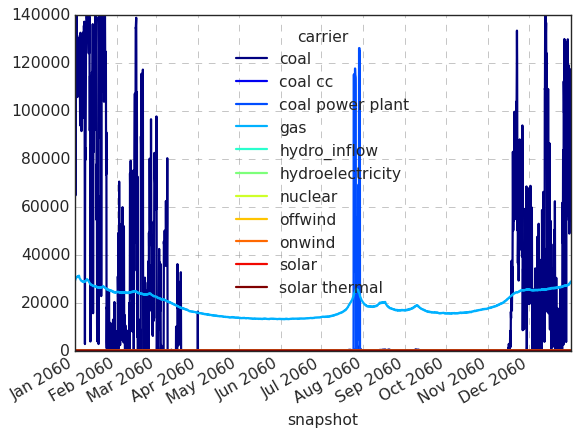

In [141]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.plot(ax =ax, cmap ="jet")

Text(0, 0.5, 'cum CO2 emissions [t]')

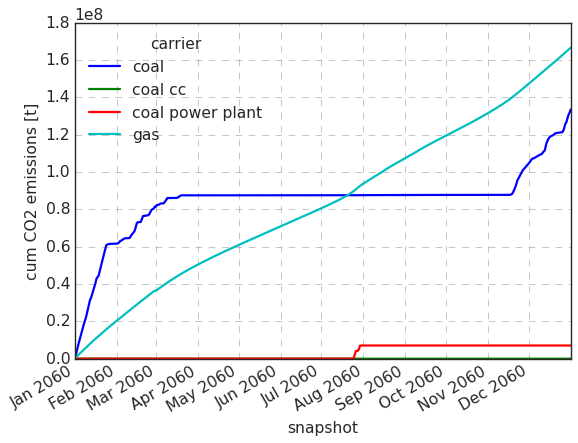

In [142]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


Text(0, 0.5, 'carrier stock')

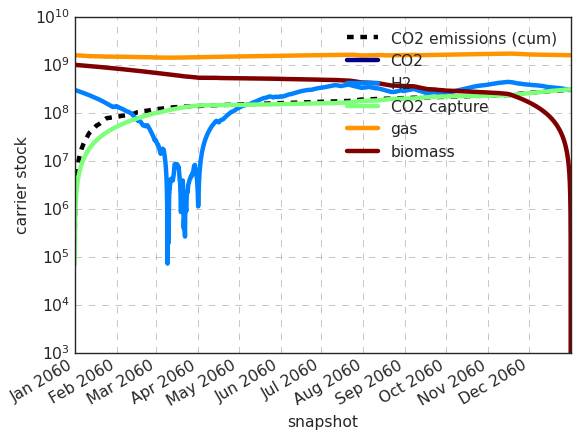

In [143]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
ax.legend()
ax.semilogy()
ax.set_ylim(1e3,1e10)
ax.set_ylabel("carrier stock")

## CO2 capture
! beware the store is the difference :)

In [144]:
stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
diff = stores.iloc[:, -1] -stores.iloc[:, 0]
co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
co2_cap


307248811.2752091

<Axes: xlabel='snapshot'>

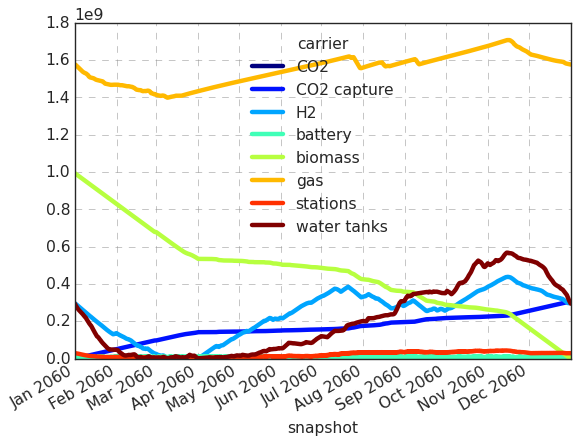

In [145]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

# plot time series

In [158]:
from plot_time_series import plot_energy_balance

In [165]:
p = (
    n.statistics.energy_balance(aggregate_time=False, bus_carrier=bus_carrier)
    .dropna(how="all")
    .groupby("carrier")
    .sum()
    .div(PLOT_CAP_UNITS)
    # .drop("-")
    .T
)

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


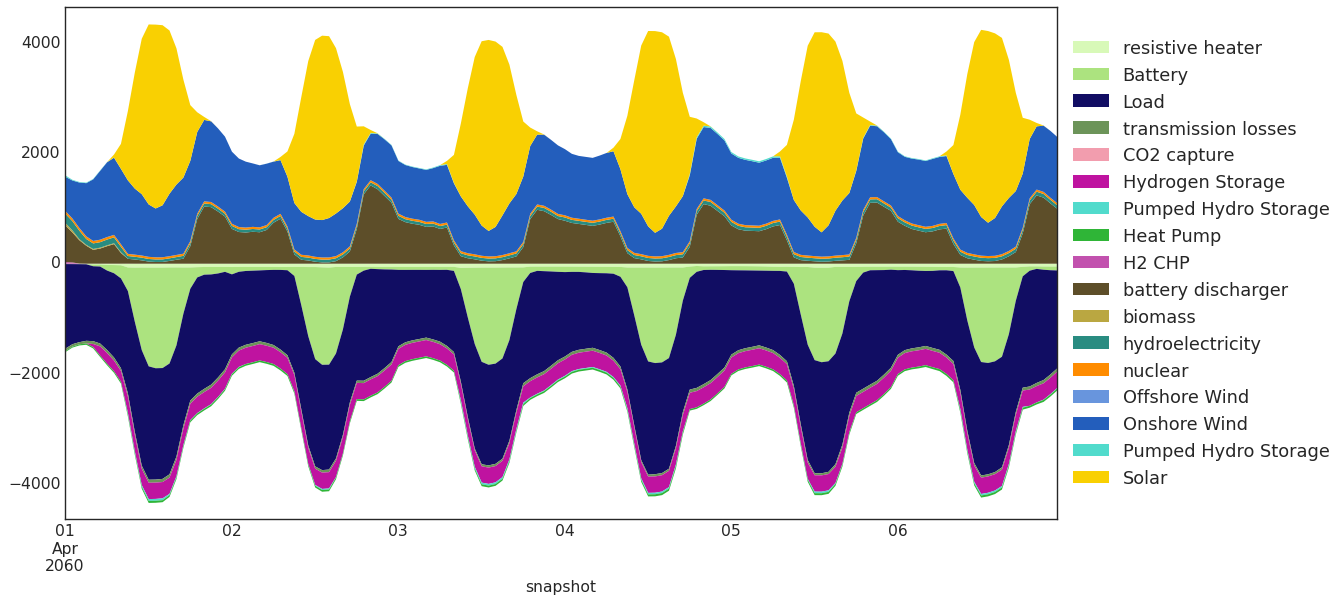

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
bus_carrier = "AC"
start_date = "2060-04-01"
end_date = "2060-04-06"
from _plot_utilities import get_stat_colors
plot_config = snakemake.config["plotting"]
p = (
    n.statistics.energy_balance(aggregate_time=False, bus_carrier=bus_carrier)
    .dropna(how="all")
    .groupby("carrier")
    .sum()
    .div(PLOT_CAP_UNITS)
    # .drop("-")
    .T
)
p.rename(columns={"-": "Load", "AC": "transmission losses"}, inplace=True)
p = p.loc[start_date:end_date]

p["coal"] = p[[c for c in p.columns if c.find("coal") >= 0]].sum(axis=1)
p["gas"] = p[[c for c in p.columns if c.find("gas") >= 0]].sum(axis=1)
p.drop(columns=[c for c in p.columns if c.find("coal") >= 0], inplace=True)
p.drop(columns=[c for c in p.columns if c.find("gas") >= 0], inplace=True)

color_series = get_stat_colors(
    p, n, plot_config, extra_colors={"Load": plot_config["tech_colors"]["electric load"]}
)
supply = p.where(p >= 0).dropna(axis=1, how="all")

color_series.rename(plot_config["nice_names"], inplace=True)
color_series.rename(
    {"battery discharger ": "Battery", "Battery Storage": "Battery"}, inplace=True
)
supply.rename(columns=plot_config["nice_names"], inplace=True)
preferred_order = plot_config["preferred_order"]
plot_order = (
    supply.columns.intersection(preferred_order).to_list()
    + supply.columns.difference(preferred_order).to_list()
)
supply = supply.reindex(columns=plot_order)

charge = p.where(p < 0).dropna(how="all", axis=1)
charge.rename(columns=plot_config["nice_names"], inplace=True)
supply.rename(columns={"battery discharger": "Battery"}, inplace=True)
charge.rename(columns={"Battery Storage": "Battery"}, inplace=True)
# charge.rename(columns=tech_names_map, inplace=True)

color_series.index = color_series.index.str.strip()
plot_order_charge = [name for name in preferred_order if name in charge.columns] + [
    name for name in charge.columns if name not in preferred_order
]
charge = charge.reindex(columns=plot_order_charge)
if not charge.empty:
    charge.plot.area(ax=ax, linewidth=0, color=color_series.loc[charge.columns])
supply.plot.area(
    ax=ax,
    linewidth=0,
    color=color_series.loc[supply.columns],
)
ax.legend(ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=16)
ax.set_ylim(charge.sum(axis=1).min() * 1.07, supply.sum(axis=1).max() * 1.07)
ax.grid(axis="y")


In [194]:
color_series

AC                      #70af1d
hydroelectricity        #298c81
hydro_inflow                   
heat                    #cc1f1f
Onshore Wind            #235ebc
Offshore Wind           #6895dd
Solar                   #f9d002
Solar Thermal           #ffbf2b
nuclear                 #ff8c00
biomass                 #baa741
Heat Pump               #2fb537
resistive heater        #d8f9b8
Sabatier                #9850ad
H2 CHP                  #c251ae
Hydrogen Storage        #bf13a0
Battery                 #ace37f
battery discharger      #5d4e29
water tanks             #e69487
Pumped Hydro Storage    #51dbcc
OCGT gas                #e0986c
CHP gas                 #8f6e6a
gas boiler              #db6a25
coal boiler             #787575
coal power plant        #545454
CHP coal                #8a5751
gas                     #e05b09
CO2 capture             #f29dae
coal carbon capture     #8487e8
stations                   pink
Load                    #110d63
transmission losses     #6c9459
Name: co

In [ ]:
color_series = get_stat_colors(
    p, n, plot_config, extra_colors={"Load": plot_config["tech_colors"]["electric load"]}
)color_series.rename(plot_config["nice_names"], inplace=True)
# color_series.index = color_series.index.str.strip()
# 

In [182]:
charge.rename(columns=plot_config["nice_names"])

carrier,Heat Pump,resistive heater,Hydrogen Storage,Battery Storage,Load,transmission losses,CO2 capture,Pumped Hydro Storage
snapshot,,,,,,,,
2060-04-01 00:00:00,-17.755940,-7.020648,-0.670412,-0.200833,-1535.930140,-41.998477,-0.901847,NaN
2060-04-01 01:00:00,-17.987345,-7.417700,-0.677738,-0.253342,-1455.579270,-42.058904,-0.777793,NaN
2060-04-01 02:00:00,-21.191145,-8.323152,-0.142755,-0.248042,-1417.392779,-37.926035,-0.387147,NaN
2060-04-01 03:00:00,-22.795271,-9.032775,-0.222243,-1.659273,-1390.321986,-48.852659,-0.326782,NaN
2060-04-01 04:00:00,-25.404219,-14.041818,-55.843335,-32.554675,-1361.030985,-51.145000,-0.326516,NaN
...,...,...,...,...,...,...,...,...
2060-04-06 19:00:00,-34.384349,-48.810793,-296.118918,-78.494897,-2103.854256,-54.817595,-0.000088,NaN
2060-04-06 20:00:00,-35.065345,-49.338029,-296.119371,-44.822260,-2072.432864,-57.647622,-0.000085,-2.285729
2060-04-06 21:00:00,-35.690446,-51.349850,-296.119602,-58.444803,-2003.753786,-60.180871,-0.000084,-5.750639


In [179]:
color_series["H2"]

'#bf13a0'

In [173]:
color_series.loc[charge.columns]

KeyError: "['heat pump', 'H2', 'battery', 'PHS'] not in index"

KeyError: "['heat pump', 'H2', 'battery', 'PHS'] not in index"

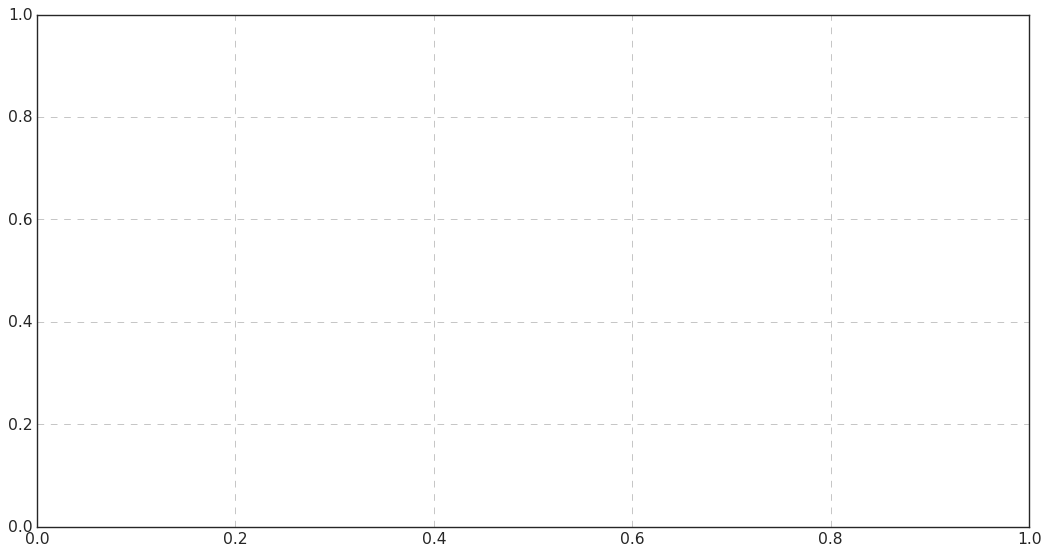

In [159]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Heat balance')

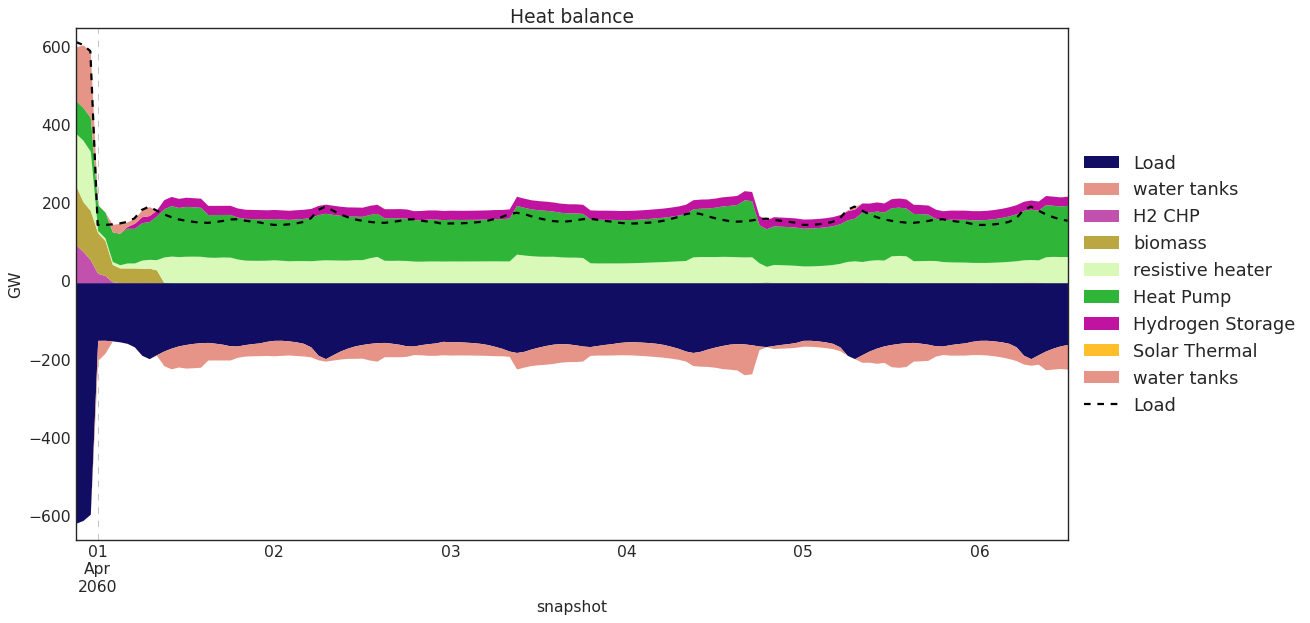

In [148]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

Text(0, 0.5, 'EnergyDemand / GW')

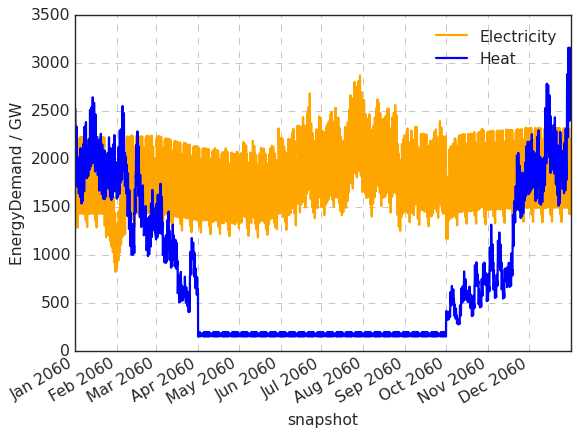

In [149]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
ds_heat.plot(ax=ax, label="Heat", c = "blue")
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

In [150]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

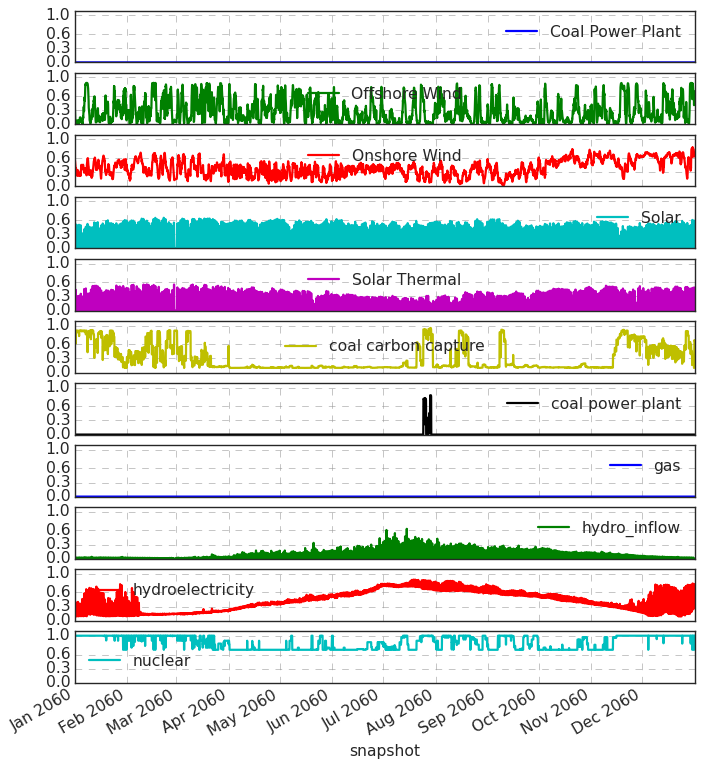

In [151]:
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12))
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

# Pypsa eur

# Plot time series (dev sandbox)

Text(0, 0.5, 'GW')

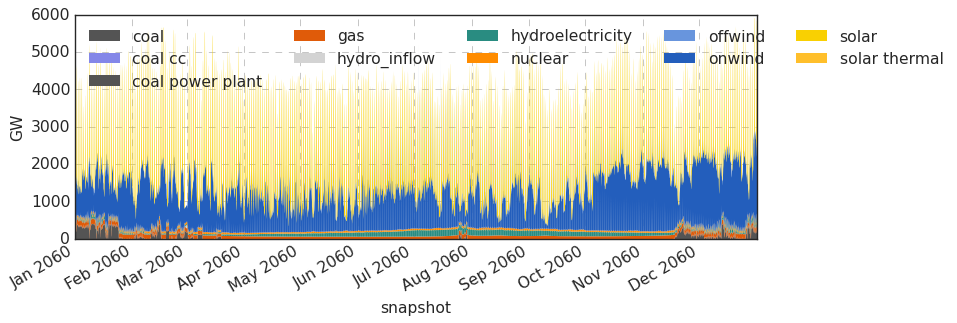

In [152]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    # cmap="tab20b",
    color = p_by_carrier.columns.map(n.carriers.color),
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

# ax.set_ylim(0, 80);

# COSTS & prices

In [153]:
stores_inflow = n.stores_t.p.sum()
h2_stores= stores_inflow.loc[[c for c in stores_inflow.index if c.find("H2 Store")!=-1]]
h2_stores_inflow = h2_stores.where(h2_stores>0,0).sum()
h2_stores_outflow = h2_stores.where(h2_stores<0,0).sum()

# STATS

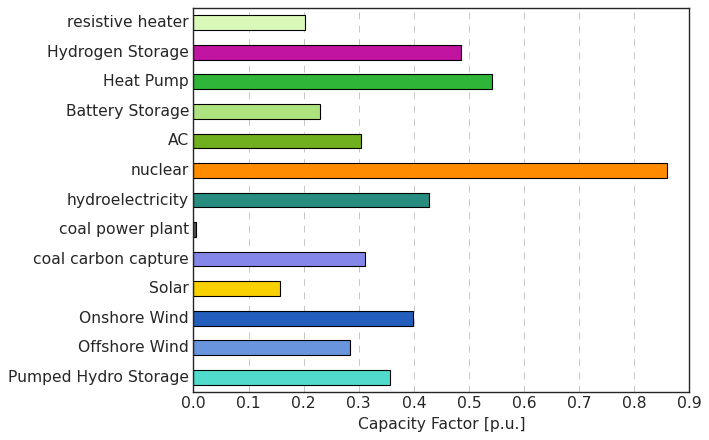

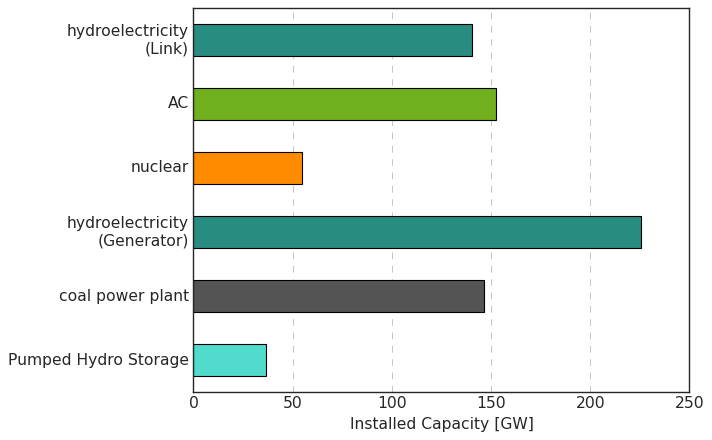

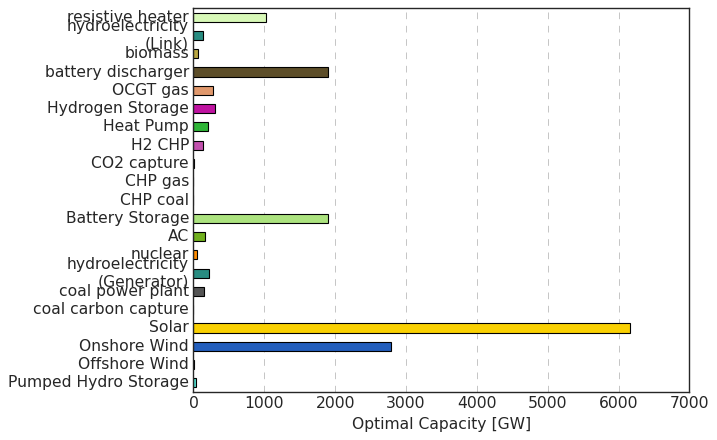

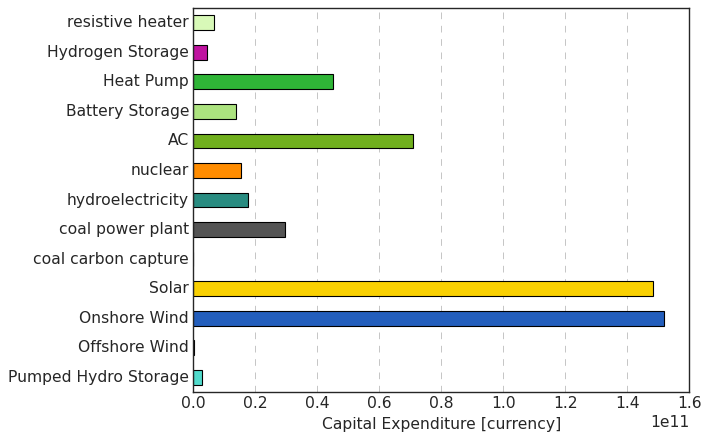

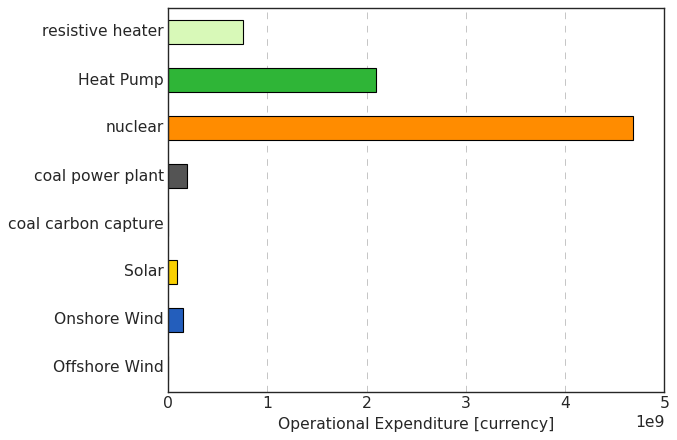

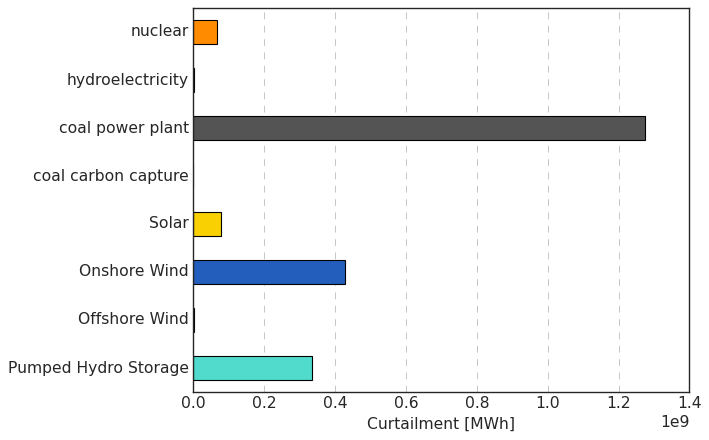

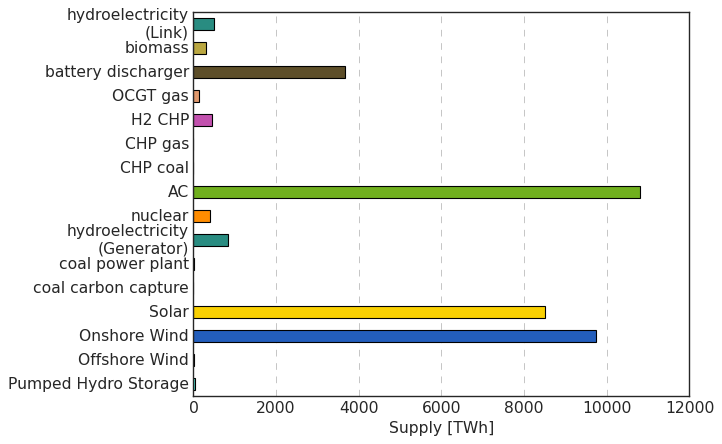

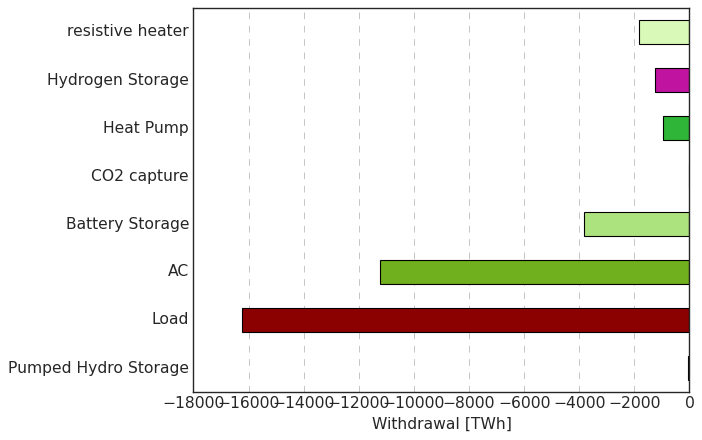

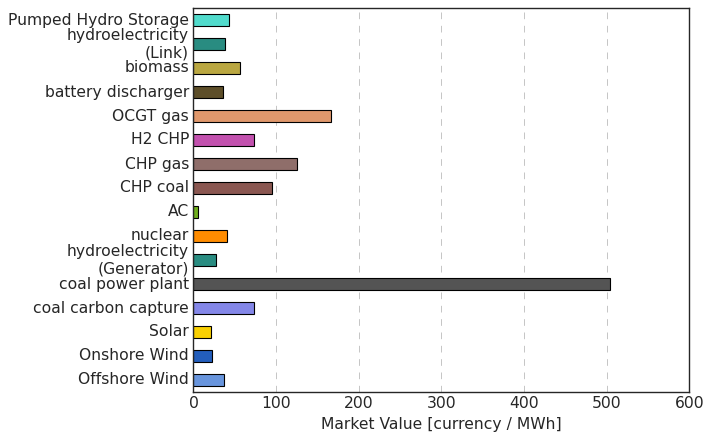

In [154]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "darkred"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [155]:
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()

ds = ds[ds != 0]
ds = ds.dropna()
c = colors[ds.index.get_level_values("carrier")]
# ds = ds.pipe(rename_index)
# label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
# ds.plot.barh(color=c.values, xlabel=label, ax=ax)
# ax.grid(axis="y")
ds

component    carrier             
StorageUnit  Pumped Hydro Storage     36390.00000
Generator    coal power plant        146354.00000
             hydroelectricity        225378.00000
             nuclear                  54647.00000
Link         AC                     -152252.22609
             hydroelectricity        140322.00000
dtype: float64

# Network topology

In [156]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

n.sub_networks



,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Anhui,<pypsa.components.SubNetwork object at 0x7ff2e...,0,1
1,AC,Beijing,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
2,AC,Chongqing,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
3,AC,Fujian,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
4,AC,Gansu,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
...,...,...,...,...,...
410,battery,Tianjin battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
411,battery,Tibet battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
412,battery,Xinjiang battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1


# EXAMPLES